# Welcome to the Matrix Element Tutorial for the LPC EFT Workshop!

We will be using the JHUGenMELA framework, which was developed (among other locations) at Johns Hopkins. Please reference the website located [here](https://spin.pha.jhu.edu/)

![logo.png](https://spin.pha.jhu.edu/droppedImage.png)

<!-- ![image-2.png](attachment:image-2.png) -->
<sup> Left --> Right </sup>

<sup> Ian Anderson , Ulascan Sarica, Andrei Gritsan (Top) Chris Martin, Roberto Covarelli (Bottom) </sup>

We will be delving into the usage of matrix-element techniques to retrieve **both** optimal observables for different hypotheses at reconstruction-level for physics analyses, as well as reweighting techniques to allow for quicker generation of new hypotheses.

**THIS NOTEBOOK WILL BE DEALING WITH HOW TO INITIALIZE MELA AND USE IT TO GENERATE WEIGHTS AND RE-WEIGHT AT GEN-LEVEL. WHILE IT WILL BE TOUCHED UPON, GO TO PART 2 TO UNDERSTAND OBSERVABLES**

## Setup

Environment variables are very important to setting up JHUGenMELA - let's check all of them before you start!

**PLEASE FOLLOW THE INSTRUCTIONS IN README.md TO SET UP WHAT IS REQUIRED HERE**

In [1]:
import os
import sys
import ipywidgets as widgets
from IPython.display import Image, display
import helpers
import importlib
importlib.reload(helpers)

<module 'helpers' from '/eos/home-m/msrivast/CMSSW_14_0_0/src/cmseft/reweighting/helpers.py'>

In [2]:
tracker = helpers.TrackProgress_MELA()

### These lines help us debug what could be going wrong

In [3]:
print(os.getcwd())

/eos/home-m/msrivast/CMSSW_14_0_0/src/cmseft/reweighting


In [4]:
print(os.environ["CMSSW_BASE"])

/eos/home-m/msrivast/CMSSW_14_0_0/src/cmseft/reweighting/CMSSW_14_0_0


In [5]:
print(os.environ['MELA_LIB_PATH'])

/eos/home-m/msrivast/CMSSW_14_0_0/src/cmseft/reweighting/CMSSW_14_0_0/src/JHUGenerator.v7.5.7/JHUGenMELA/MELA/data/el9_amd64_gcc12


In [6]:
assert (
    os.environ['MELA_LIB_PATH']
    == 
    f"{os.environ['CMSSW_BASE']}/src/JHUGenerator.v7.5.7/JHUGenMELA/MELA/data/el9_amd64_gcc12"
)

In [42]:
import uproot
import subprocess
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
import enum
import hist
import tqdm
import pprint

# What is the "Matrix Element"?

Recall your grad-level QFT course - remember the S-matrix? To quote Weinberg QFT, "The S-matrix $S_{\beta\alpha}$ is the probability amplitude for the transition $\alpha\rightarrow\beta$". This S-matrix is the namespace of the "Matrix-Element Method".

This excerpt might make things clearer, from Mark Thomson's *Modern Particle Physics*: 
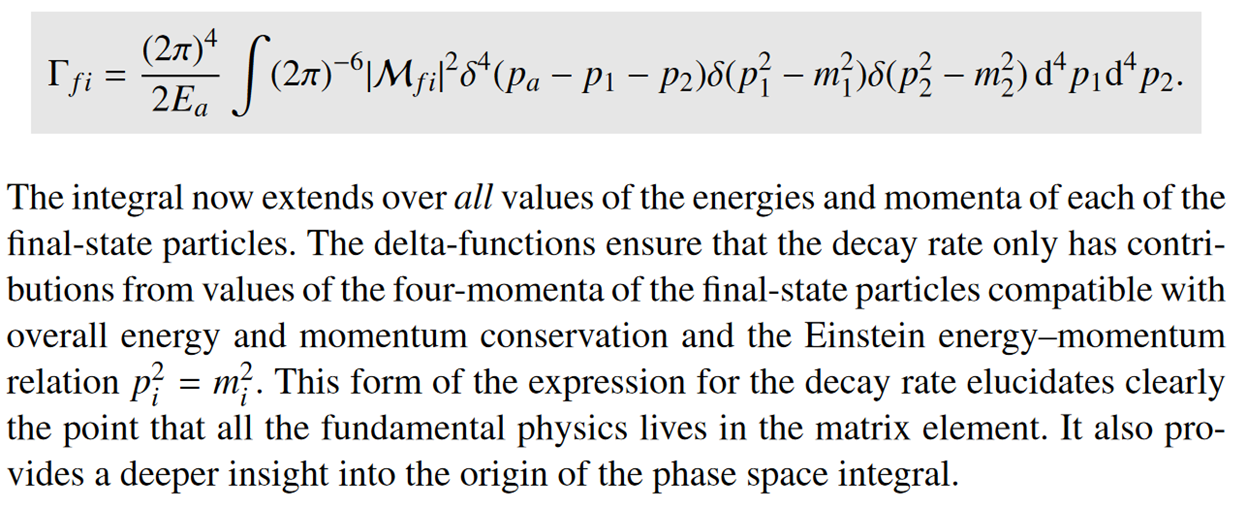

While this is the case for decays to final-state particle $f$ from initial state particle $i$, we can also include PDF weights to sum over initial states to get production-dependent "matrix elements" (not really matrix elements, but functionally the same thing for our purposes).

For well-defined processes where nice theorists have already calculated these matrix elements for a variety of different interactions, such as $H\rightarrow ZZ$ decays, these matrix elements are invaluable.

## What about when you don't know the initial state? Like in real data!?

Well lucky reader, smarter people than I have accounted for this. One can sum over the set of all initial states to create observables that are sensitive to the kinematic differences between processes. If you are at all familiar with the decay angles in 4-lepton decay, the matrix-element encodes all of those angles.

Probably the most important observable in HEP-EX is $D_{bkg}$, or the observable quantity that separates signal from background!

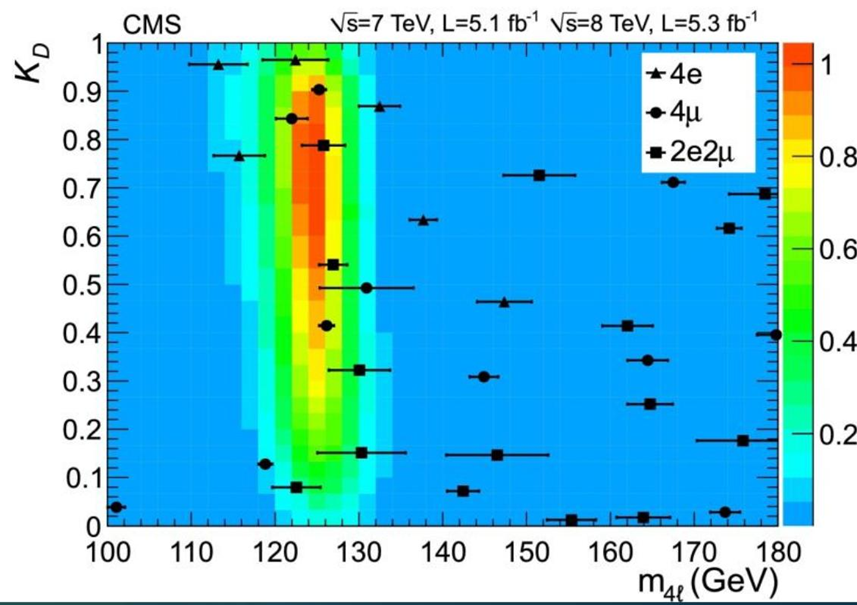

# Weights in Physics

Weighted histograms appear everywhere in HEP! Generators often produce weighted histograms that show a distribution as opposed to unweighted events one-by-one, as that is much faster. Really what they are is a representation of how many events you expect in whatever phasespace you expect.

Madgraph, and every generator at higher-orders utilize weights to do real physics. In the realm of EFT, we can use these weights to ascribe very specific meaning to show how one hypothesis can shift to another.

### Relation to the Matrix-Element

In NLO/NNLO/NN(...)LO generators, oftentimes events will have specific weights attached to them to showcase the relative contribution of specific events. This is why negative weights are sometimes an issue, as sometimes interference will drop the yield due to NLO effects. **Keep in mind, due to this (among other issues) - reweighting at NLO/NNLO/etc. is really unwieldy. We will be doing this at LEADING-ORDER**.

In this case, what you're really doing is **replacing** the matrix-element that describes your sample hypothesis, with the one that describes the physics that you want. **As long as your initial state and your final state are the same, you can nominally reweight to anything that you would like**. This is why ***Reweighting can only be done with gen-level quantities***.

Let's assume that your sample starts with some hypothesis $P_{\text{SAMPLE}}$, which is the result of some set of couplings. Now, let's say you start at Gen level and want a sample $P_{\text{TARGET}}$, you would do the following:

1. Compute $P_{\text{SAMPLE}}$ for each event
2. Compute $P_{\text{TARGET}}$ for each event
3. Apply $w=\frac{P_{\text{TARGET}}}{P_{\text{SAMPLE}}}$ to each event to re-weight the sample

### Let's do a stupid example!

Let's imagine that the entirety of the information here is contained within these histograms for $P_{\text{SAMPLE}}$ and $P_{\text{TARGET}}$, and the "weight" is just the ratio of the 2 histograms. Notice that re-weighting is really only successful when **the two samples share some sort of phase space**. Background can be reweighted to signal, but signal cannot recreate background!

**When re-weighting, it is important that you use a variety of different samples such that you can sample the entire phase-space of the hypothesis you are re-weighting to**.

AssertionError: 

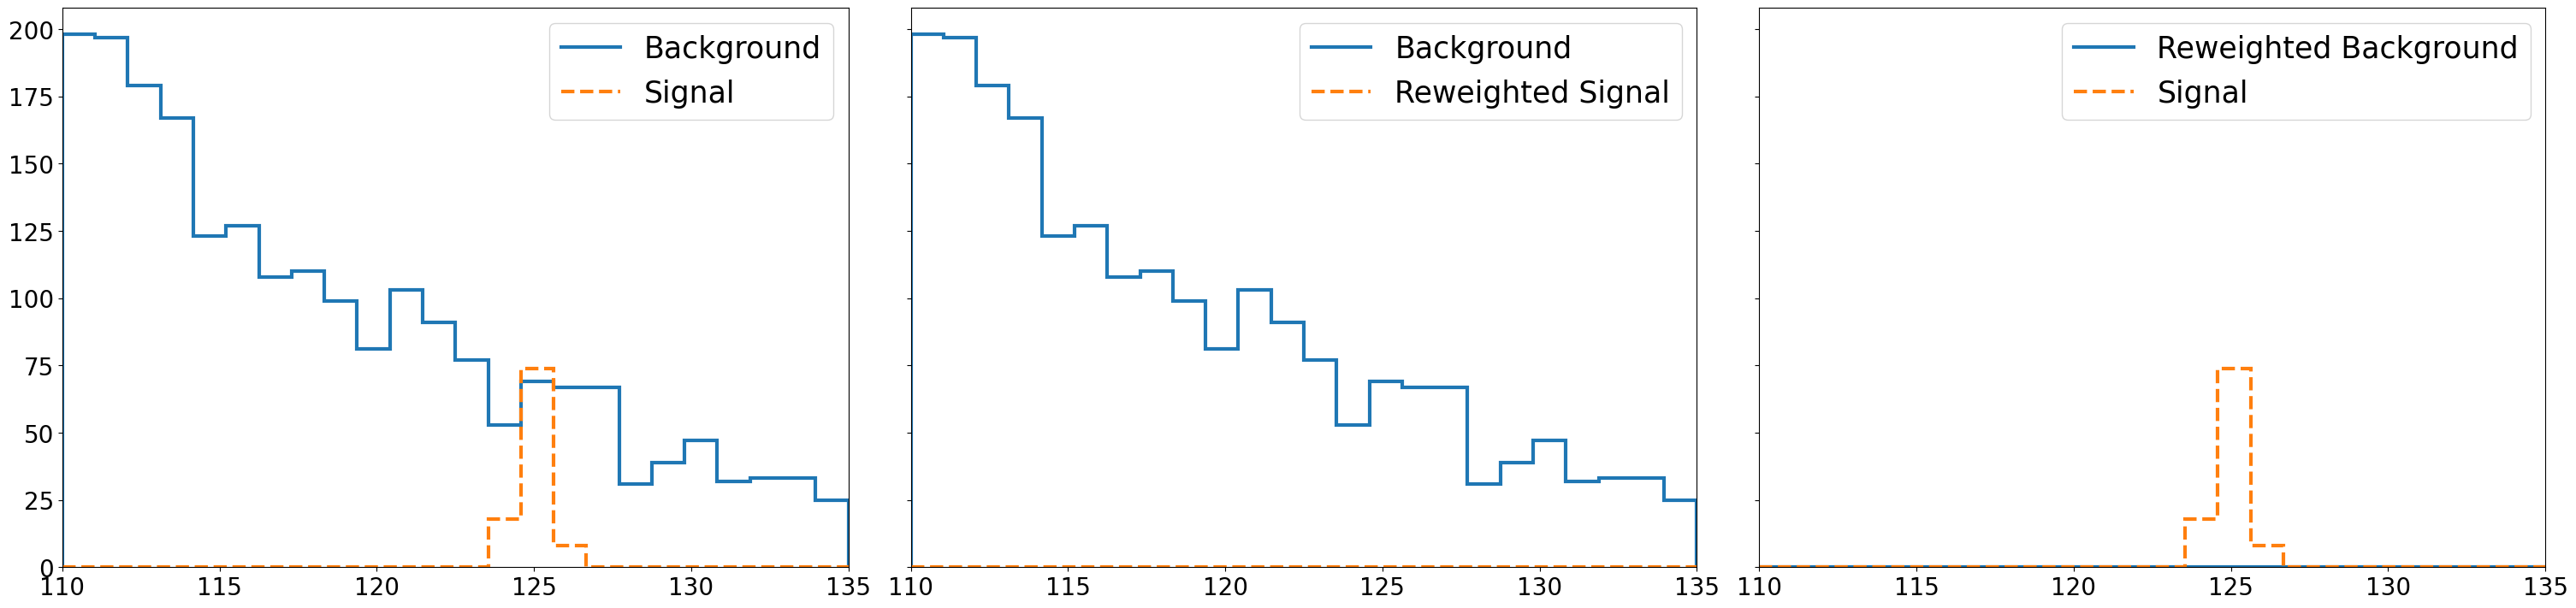

In [23]:
fig, axs = plt.subplots(1,3,layout="constrained", figsize=(30,7), sharey=True)
EFT_signal = np.random.normal(125, 0.5, 100)
background = 110 + 25*np.random.exponential(0.5, 2500)
binning = np.linspace(110, 135, 25)

EFT_signal_hist, _ = np.histogram(EFT_signal, binning)
background_hist, _ = np.histogram(background, binning)

hep.histplot(
    [background_hist, EFT_signal_hist], binning, 
    label=["Background", "Signal"], ax=axs[0], lw=3, linestyle=["solid", "dashed"]
)

#USING THE HISTOGRAM COUNTS FOR "EFT SIGNAL" AND "BACKGROUND" AS YOUR "PROBABILITY", 
#RE-WEIGHT EACH ONE TO LOOK LIKE THE OTHER
#Use the assert check as a hint!

wgt_sig_to_bkg = 0
wgt_bkg_to_sig = 0

hep.histplot(
    [background_hist, EFT_signal_hist*wgt_sig_to_bkg], binning, 
    label=["Background", "Reweighted Signal"], ax=axs[1], lw=3, linestyle=["solid", "dashed"]
)

hep.histplot(
    [background_hist*wgt_bkg_to_sig, EFT_signal_hist], binning, 
    label=["Reweighted Background", "Signal"], ax=axs[2], lw=3, linestyle=["solid", "dashed"]
)

for ax in axs:
    ax.set_xlim(110, 135)
    ax.legend(fontsize=25, loc="upper right")
    ax.tick_params(labelsize=20)
fig.show()

assert np.array_equal(background_hist*wgt_bkg_to_sig, EFT_signal_hist)
assert np.any(EFT_signal_hist*wgt_sig_to_bkg == background_hist)


# Observables in Physics

**We are experimentalists** - we need observables to help differentiate signal from background! The matrix element method was crucial to the discovery of the Higgs boson, as it allowed for an efficient observable to be crafted to allow for this.

This is doubly important in EFT, where effects are small enough where we can't do noticeable bump searches from the naked eye!

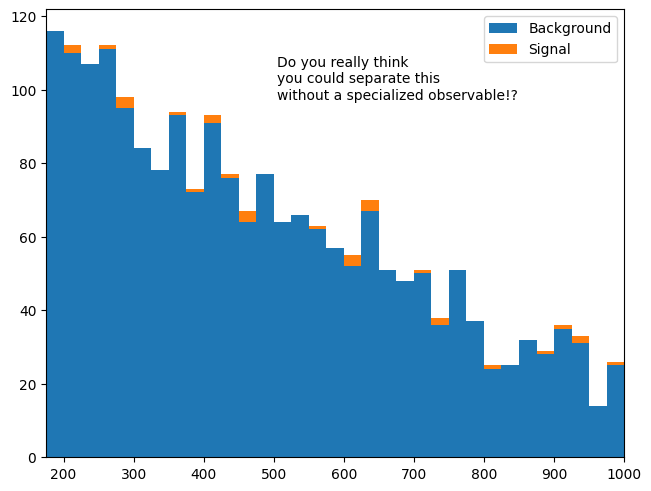

In [125]:
fig, ax = plt.subplots(1,1,layout="constrained")
EFT_signal = np.random.uniform(200, 1000, 30) #Imagine a rare EFT process that is seen above the top mass
background = 175 + 1000*np.random.exponential(0.5, 2500)
binning = np.arange(175, 1001, 25)
ax.hist([background, EFT_signal], binning, stacked=True, label=["Background", "Signal"])
ax.set_xlim(175, 1000)
ax.text(0.4, 0.8, "Do you really think\nyou could separate this\nwithout a specialized observable!?", transform=plt.gca().transAxes)
ax.legend()
fig.show()

# Initializing Your MELA Object

The MELA object is available in both Python and in C++. Both are pre-compiled libraries, with the Python library utilizing PyBind11 in order to create the bindings, which have been available as of July 2024. There are also a slew of other things stored in the Mela Python library, which we will go over!

**Note that there is documentation for JHUGenMELA that is located [on the website](https://spin.pha.jhu.edu/MELA/). Everything that we will be doing pertains to the section called [PyMela](https://spin.pha.jhu.edu/MELA/PyMela_page.html)**.

**We will be referring back to this documentation *constantly*! So please familiarize yourself with it**

In [24]:
import Mela

The `Mela` package contains a large number of different C++ classes that are required to interface with the underlying FORTRAN functions through the existing MELA functionality. Let's see what they are.

For any python object or module one can call `dir` to see all of its possible attributes.

**call dir on the Mela module below to see everything that is contained within the package. Most of these "classes" are enumerations, but MELACandidate, MELAParticle, MELAThreeBodyDecayCandidate, SimpleParticle_t, and SimpleParticleCollection_t are actual classes**

In [24]:
dir(Mela)

['CandidateDecayMode',
 'CouplingIndex_ATQGC',
 'CouplingIndex_AZff',
 'CouplingIndex_GGG',
 'CouplingIndex_GQQ',
 'CouplingIndex_GVV',
 'CouplingIndex_HGG',
 'CouplingIndex_HQQ',
 'CouplingIndex_HVV',
 'CouplingIndex_HVV_CQSQ',
 'CouplingIndex_LAMBDAQSQ',
 'CouplingIndex_SMEFT',
 'CouplingIndex_Vpff',
 'CouplingIndex_ZQQ',
 'CouplingIndex_ZVV',
 'EventScaleScheme',
 'FermionMassRemoval',
 'LeptonInterference',
 'MELACandidate',
 'MELAParticle',
 'MELAThreeBodyDecayCandidate',
 'MatrixElement',
 'Mela',
 'PrintCandidateSummary',
 'Process',
 'Production',
 'ResonancePropagatorScheme',
 'SimpleParticleCollection_t',
 'SimpleParticle_t',
 'SuperMelaSyst',
 'VerbosityLevel',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'event_scales_type',
 'simple_event_record']

### How do Enumerations Work?

An enumeration (enum) is just a really fancy way of storing constants that represent *something*. In the case of MELA, all of the enums are integers, and represent different values that are used throughout. 

There are a lot of ways to get the values for a certain enum - let's explore that for a moment

In [29]:
dir(Mela.VerbosityLevel)

['DEBUG',
 'DEBUG_MECHECK',
 'DEBUG_VERBOSE',
 'ERROR',
 'INFO',
 'SILENT',
 '__and__',
 '__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__entries',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__index__',
 '__init__',
 '__init_subclass__',
 '__int__',
 '__invert__',
 '__le__',
 '__lt__',
 '__members__',
 '__module__',
 '__ne__',
 '__new__',
 '__or__',
 '__rand__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__ror__',
 '__rxor__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__xor__',
 'name',
 'value']

### Try and pass this assert statement

In [70]:
i = Mela.VerbosityLevel.SILENT
assert i.value == 5 and i.name == "DEBUG_MECHECK"
tracker.enum_pass()

AssertionError: 

The constructor can be found [here](https://spin.pha.jhu.edu/MELA/MELA_python.html) in Python as an example, with the underlying C++ function found [here](https://spin.pha.jhu.edu/MELA/classMela.html#aa0d92c0d836f7c720f584dc75a8031fc). **Note that all the actual function signatures are documented within the C++ area, as that is where the functions are actually defined**.

In [68]:
#MELA is initialized as (Center-of-Mass Energy, Higgs Mass, Verbosity)
m = Mela.Mela(13, 125, Mela.VerbosityLevel.DEBUG)

 ************** MCFM - version 7.0 ****************
 *                                                *
 * MCFM, v7.0                   March 20th, 2015  *
 *                                                *
 * Authors: John Campbell, Keith Ellis,           *
 *          Walter Giele, Ciaran Williams         *
 *         (johnmc@fnal.gov, ellis@fnal.gov,      *
 *          giele@fnal.gov,ciaran@fnal.gov)       *
 *                                                *
 * For details see:                               *
 *                                                *
 *  arXiv:1502.02990 (VBF and VBS Higgs)          *
 *  arXiv:1403.2641  (Triphoton production)       *
 *  arXiv:1312.1628  (gg->WW, Higgs interference) *
 *  arXiv:1311.3589  (gg->ZZ, Higgs interference) *
 *  Phys.Rev.D87:114006, arXiv:1302.3856          *
 *  (tZ, tH -- with R. Rontsch)                   *
 *  arXiv:1211.6390 (DM, P. Fox and C. Williams)  *
 *  JHEP 1211:162 (2012), arXiv:1208.0566         *
 *  (Z+gam+j

Note the number of other people credited! This package is a team effort done across many different generators to try and utilize what is best.

At a glance, the JHUGenerator, MCFM, Madgraph, and SMEFTSim teams are explicitly credited as their matrix elements are used directly.

## Couplings

Couplings define interactions between various particles. In MELA within C++, couplings are stored within arrays and indexed via the couplingIndex enumerations you saw earlier.


The couplings utilized by JHUGen and MCFM are in what is known as the "amplitude basis", which directly affects the amplitudes of various processes for the Higgs boson. There is a conversion to the commonly-used EFT Warsaw Basis, and we will cover that soon.

**This is where things get a little wierd**. MCFM supports 2 resonances (made for high-mass analyses), so many arrays are of dimension (2, N-couplings, 1 or 2), where the first dimension is for each resonance, the second the number of couplings the array contains, and the third either 1 or 2 depending on if the couplings are real only or can also imaginary.


**As an example, let's look at selfDHggcoupl, or the array containing the Higgs coupling to gluons**. These are output as normal numpy ndarrays, and so you can do with them whatever you'd like!

Remember that editing the numpy array without calling `ndarray.copy()` will edit terms in-place.

In [59]:
#coupling arrays in Mela have to be called as functions since it's retrieving the C-style array
print(m.selfDHggcoupl())
print(m.selfDHggcoupl().shape)

[[[0. 0.]
  [0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]
  [0. 0.]]]
(2, 3, 2)


Let's say you want to set `ghg2`, or the point-like approximation of the gluon-fusion loop coupling to the Higgs, to 1, or the Standard Model value. Remember that couplings are set as `array[Resonance_Index][coupling_enum][real/imaginary]`. 

**To help you out, the coupling enum you want to use is `CouplingIndex_HGG.gHIGGS_GG_2`**

In [78]:
indices = (None, None, None)
m.selfDHggcoupl()[indices] = 0
assert np.array_equal(m.ghg2, [1,0])
coupling_pass()

AssertionError: 

## DOING THINGS THIS WAY IS A HUGE PAIN!

This is why, just for you, the MELA team devised a series of names for each and every coupling that can be used very easily. You saw this used just above. It is shown how to do that below:
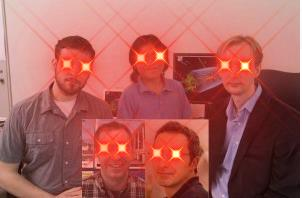

In [77]:
ghg_array = m.selfDHggcoupl()
m.ghg2 = [1,0]
m.gh2g2 = [1,0]
print("before:")
print(ghg_array)

m.ghg2 = [100,0] #for example
m.gh2g2 = [100,0]
print("after")
print(ghg_array)

before:
[[[1. 0.]
  [0. 0.]
  [0. 0.]]

 [[1. 0.]
  [0. 0.]
  [0. 0.]]]
after
[[[100.   0.]
  [  0.   0.]
  [  0.   0.]]

 [[100.   0.]
  [  0.   0.]
  [  0.   0.]]]


### The entire list of couplings that could possibly be used are listed [at this page in the documentation](https://spin.pha.jhu.edu/MELA/MELA_couplings_table.html).

The nomenclature generally goes `g<particle1><particle2><number>`. Usually particle 1 is the Higgs, denoted by `h`, and whenever the number is 1 that indicates the Standard Model coupling. Whenever there is a `2` in front of `h`, that denotes the coupling for the second resonance.

The convention for the Higgs amplitude basis is linked in the following papers: [ArXiv:2002.09888](https://arxiv.org/abs/2002.09888) and [ArXiv:2109.13363](https://arxiv.org/abs/2109.13363).

There are a huge number of couplings, **including** couplings between the Z and fermions, which can be found at the bottom of the table linked in the header belonging to the `selfDAZffcoupl` array.

### Try setting the value of the Standard Model coupling between the Higgs and the Z Boson (which follows the style `g<particle1><particle2><number>`) to be $i$

**It's really easy to cheat here - DON'T DO IT!**

In [82]:
m.ghz<SOMETHING> = None #change this line!

assert np.array_equal(m.selfDHzzcoupl()[(0, Mela.CouplingIndex_HVV.gHIGGS_VV_1)], [0,1])
tracker.named_coupling_pass()

SyntaxError: invalid syntax (270610986.py, line 1)

## But I thought we were doing EFT????

There is a handy tool to convert between the Higgs and Warsaw bases, and that comes in the form of JHUGenLexicon, which is part of the JHUGen package. Currently, it is tuned for Higgs to vector vector decays, so $H\rightarrow ZZ$ and $H\rightarrow WW$. But these relations can hold up more generally.

**The manual for JHUGenLexicon exists in the same place as the JHUGenerator Manual, which is located [here](https://spin.pha.jhu.edu/Manual.pdf)**

### The couplings that are output here are what we will be reweighting to in our example for gluon-fusion

In [38]:
JHU_lexicon = "CMSSW_14_0_0/src/JHUGenerator.v7.5.7/JHUGenLexicon/JHUGenLexicon"
higgs_basis_conversion = subprocess.check_output([
    JHU_lexicon, 
    "input_basis=warsaw",
    "HZ_couplings_only=true",
    "output_basis=eft_jhu",
    "tcHWB=1,0", #cHWB tilde
]).decode('utf-8')
print(higgs_basis_conversion)

ghg2=0,0 ghgsgs4=0.0511176,0 ghzgs4=0.0325928,0 ghgsgs2=0,0 ghzgs2=0,0 ghz4=-0.0511176,0 ghg4=0,0 ghz2=0,0 ghz1_prime2=0,0 ghz1=2,0



## Setting up your MELA object's mode

In order to run properly, we must input the proper production mode and process that we are providing. Similarly, we need to also state the "*matrix element*" we will be using (essentially which generator's calculations are we taking).

Here are generally how the Matrix Elements (and their usage) generally shakes out:

| "Matrix Element" | Usage | Basis |
| ---------------- | ----- | ----- |
| JHUGen           | single-resonance Spin-0, Spin-1, Spin-2 resonances | Higgs Basis |
| MCFM             | single or doubly resonant Spin-0 particles, often used for off-shell $H$ | Higgs Basis |
| Madgraph         | Currently only available for $gg\rightarrow H$ signal, but will be expanded | Warsaw Basis |

For now, we will be using the MCFM Matrix Elements for gluon fusion.

For the combination of processes and productions that are possible, check [here](https://spin.pha.jhu.edu/MELA/tvar_enums.html). 

**To make your life easier, I am telling you that we will be using Mela.Production.ZZGG and Mela.Process.HSMHiggs**.


In [99]:
m.setProcess(Mela.Process.HSMHiggs, Mela.MatrixElement.JHUGen, Mela.Production.ZZGG)

# Compute Functions

Mela has 3 compute functions for probabilities - `computeP`, `computeProdP`, and `computeProdDecP`. Use `computeP` for any processes that are decay only, `computeProdP` for production-side reweighting, and `computeProdDecP` for a combination of the two. 

**Every time you call a compute function, the couplings are wiped away! This is because MELA pre-dates columnar analysis formats, so we will have to utilize an event loop**.

In [105]:
m.ghz1 = [1,0]
m.ghg2 = [1,0]
print(f"Setting ghz1 to {m.ghz1} and ghg2 to {m.ghg2}")
print("The resulting probability is:", m.computeP(False))
print(f"After computation, ghz1 = {m.ghz1} and ghg2 = {m.ghg2}")

Setting ghz1 to [1. 0.] and ghg2 to [1. 0.]
The resulting probability is: 0.0
After computation, ghz1 = [0. 0.] and ghg2 = [0. 0.]


# Setting Input Events

The probability is 0 because there were no input events! 

**My personal choice is to pre-compute all the input events, the utilize them in the event loop for multiple different hypotheses**.

Inpute events are set using `Mela.Mela.setInputEvent` (which is based off of the C++ `Mela::setInputEvent`), which takes in a `Mela.SimpleParticleCollection_t`, which is really just a vector made of `SimpleParticle_t`, which is a pair consistent of a PDG ID and a Lorentz Vector. The code in C++ looks as such:

```cpp
typedef std::pair<int, TLorentzVector> SimpleParticle_t;
typedef std::vector<SimpleParticle_t> SimpleParticleCollection_t;
```

The documentation is available for all the following:

- [SimpleParticle_t](https://spin.pha.jhu.edu/MELA/SimpleParticle_t.html)
- [SimpleParticleCollection_t](https://spin.pha.jhu.edu/MELA/SimpleParticleCollection_t.html)
- [Mela::setInputEvent](https://spin.pha.jhu.edu/MELA/classMela.html#a71142f41d44bb42a1cd2be50b3cc8240)


In [107]:
dir(Mela.SimpleParticleCollection_t)

['MTotal',
 'Sum',
 '__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setitem__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'add_particle',
 'toList']

Here we are simply building an awkward array that represents the output from a single gluon-fusion event coming out of JHUGen. If you want to check out the HATS tutorial on Awkward Arrays, see [here](https://awkward-array.org/doc/main/getting-started/uproot-awkward-columnar-hats.html).
But generally the data is retrieved (in this case) via `ggH_test_data.<field>`. So, if you wanted to access the


### Mela has a bit of a weird naming scheme with regards to what particles are where

* "Mother" particles are the initial state particles that we don't see in reconstruction (so gluons or quarks).
* "Daughter" particles are the final-state leptons or whatever from the hard scattering process
* "Associated" particles are jets



In [31]:
ggH_test_data = ak.Record({
    "LHEMotherId" : [21,21],
    "LHEMotherPx" : [0, 0],
    "LHEMotherPy" : [0, 0],
    "LHEMotherPz" : [5.37086667033E+02, -7.27293062837E+00],
    "LHEMotherE"  : [5.37086667033E+02, 7.27293062837E+00],
    
    "LHEDaughterId" : [11, -11, 12, -12],
    "LHEDaughterPx" : [-4.96385765951E+00, 3.89098702611E+00, 8.04215953543E+00, -6.96928890202E+00],
    "LHEDaughterPy" : [ 1.62933935971E+01, 4.04799485238E+00,-2.29213235677E+01, 2.57993511828E+00],
    "LHEDaughterPz" : [2.11696003997E+02, 1.06735429842E+00, 2.77968427622E+01, 2.89253535347E+02],
    "LHEDaughterE"  : [2.12380113632E+02, 5.71535544142E+00, 3.69151442044E+01, 2.89348984384E+02]
})

Utilizing the data above, let's construct 2 different `SimpleParticleCollection_t` objects below that contain the information for both the gluons as well as all 4 leptons. 

**Remember that the documentation for `SimpleParticleCollection_t` is [here](https://spin.pha.jhu.edu/MELA/SimpleParticleCollection_t.html)!**

In [35]:
initial_particles = Mela.SimpleParticleCollection_t(
    ggH_test_data.LHEMotherId,
    ggH_test_data.LHEMotherPx,
    ggH_test_data.LHEMotherPy,
    ggH_test_data.LHEMotherPz,
    ggH_test_data.LHEMotherE
)
print(f"Overall mass of the gluons is {initial_particles.MTotal()}")

final_particles = Mela.SimpleParticleCollection_t(
    ggH_test_data.LHEDaughterId,
    ggH_test_data.LHEDaughterPx,
    ggH_test_data.LHEDaughterPy,
    ggH_test_data.LHEDaughterPz,
    ggH_test_data.LHEDaughterE
)
print(f"Overall mass of the leptons is {final_particles.MTotal()}")


Overall mass of the gluons is 124.9991054111503
Overall mass of the leptons is 124.99916889148233


# Taking Advantage of Meta-Programming

In Python, there are string evaluation functions, which are really quite useful when it comes to anything regarding MELA couplings. For instance, let us remind ourselves of the JHUGenLexicon output from earlier. We can split this up in a way that Python can set those couplings using just the output from Lexicon, rather than setting them individually. This allows for you to create "sets" of couplings. For example,

```python
couplings = [
    {
        "COUPLING1":[1,0],
        "COUPLING2":[0,1]
    },
    {
        "COUPLING1":[0,1],
        "COUPLING2":[1,0]
    }
]
for hypo_dict in couplings:
    for coup_name, coup_val in hypo_dict.items():
        setattr(m, coup_name, coup_val)
```

In [72]:
print(higgs_basis_conversion)

coupling_setups = {
    #MCFM simulates the gluon-fusion loop, so kappa_top and kappa_bot are the coupling strengths of the Higgs 
    #to the top and bottom quarks, respectively
    "SM" : {"ghz1" : [1,0], "kappa_top" : [1,0], "kappa_bot" : [1,0]},
    "tchWB" : dict()
}
for coupling_and_val in higgs_basis_conversion.strip().split():
    coupling, val = coupling_and_val.split('=')
    val = [float(i) for i in val.split(',')]
    coupling_setups["tchWB"][coupling] = val

pprint.pprint(coupling_setups)

ghg2=0,0 ghgsgs4=0.0511176,0 ghzgs4=0.0325928,0 ghgsgs2=0,0 ghzgs2=0,0 ghz4=-0.0511176,0 ghg4=0,0 ghz2=0,0 ghz1_prime2=0,0 ghz1=2,0

{'SM': {'ghz1': [1, 0], 'kappa_bot': [1, 0], 'kappa_top': [1, 0]},
 'tchWB': {'ghg2': [0.0, 0.0],
           'ghg4': [0.0, 0.0],
           'ghgsgs2': [0.0, 0.0],
           'ghgsgs4': [0.0511176, 0.0],
           'ghz1': [2.0, 0.0],
           'ghz1_prime2': [0.0, 0.0],
           'ghz2': [0.0, 0.0],
           'ghz4': [-0.0511176, 0.0],
           'ghzgs2': [0.0, 0.0],
           'ghzgs4': [0.0325928, 0.0]}}


Now we will try and re-weight a standard model sample for gluon-fusion that is located at `SAMPLE/SM_Higgs.root`.

**Note that in experimental settings, we often record the $p_t, \eta, \phi$ and mass of the final state particles, and that we assume the gen-level initial state particles are only coming down the beam pipe.**

This means that we do 2 things:
- Set $p_x$ and $p_y$ for the mother particles as 0
- Utilize the `ptEtaPhi` flag for SimpleParticleCollection_t, e.g.:

```python
lepton_Collection = Mela.SimpleParticleCollection_t(
     [13, -13, 11, -11],
     [pt1, pt2, pt3, pt4],
     [eta1, eta2, eta3, eta4],
     [phi1, phi2, phi3, phi4],
     [mu_M, mu_M, e_M, e_M],
     ptEtaPhi=True
)
```

- There are no jets at LHE-level, so we input `None` for Associated Particles

**We will sync up the input data with the inputs required for [setInputEvent](https://spin.pha.jhu.edu/MELA/classMela.html#a71142f41d44bb42a1cd2be50b3cc8240)**.

In [53]:
input_data = []

with uproot.open("SAMPLE/SM_Higgs.root") as f_in:
    data = f_in['tree'].arrays([
        "LHEMotherId",
        "LHEMotherPz",
        "LHEMotherE",
        
        
        "LHEDaughterId",
        "LHEDaughterPt",
        "LHEDaughterEta",
        "LHEDaughterPhi",
        "LHEDaughterMass"
    ])
    for i in tqdm.tqdm(range(len(data_branches)), desc="pre-processing events"):
        mothers = Mela.SimpleParticleCollection_t(
            data["LHEMotherId"][i],
            [0]*len(data["LHEMotherId"][i]),
            [0]*len(data["LHEMotherId"][i]),
            data["LHEMotherPz"][i],
            data["LHEMotherE"][i],
            False
        )
        daughters = Mela.SimpleParticleCollection_t(
            data["LHEDaughterId"][i],
            data["LHEDaughterPt"][i],
            data["LHEDaughterEta"][i],
            data["LHEDaughterPhi"][i],
            data["LHEDaughterMass"][i],
            True
        )
        associated = None
        input_data.append(
            (daughters, None, mothers)
        )
    del data

pre-processing events:   0%|                                                                                                        | 0/10000 [00:00<?, ?it/s]/tmp/msrivast/ipykernel_2014226/1814695344.py:17: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  mothers = Mela.SimpleParticleCollection_t(
/tmp/msrivast/ipykernel_2014226/1814695344.py:25: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  daughters = Mela.SimpleParticleCollection_t(
pre-processing events: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 853.76it/s]


## What are we going to re-weight?

For on-shell Higgs bosons, there really isn't a shape in the mass spectrum for us to re-weight. However, there are a lot of different kinematic observables to see! One set of such observables (which will lead us into part 2 of this tutorial) are the decay angles for vector-vector decays of the Higgs, defined at [ArXiv:1208:4018](https://arxiv.org/abs/1208.4018). This is done via the function [computeDecayAngles](https://spin.pha.jhu.edu/MELA/group__ReferenceGroup.html#gae2dd2dc5ce6cd622604bf07e125e21b6), and is showcased below. MELA can calculate these angles using the same input event that is given - so that's what we'll do. **Note that the computation of angles and the presence of couplings are independent processes. While they use the same information, the coupling values do not affect the calculation of the angles since they are directly from the input**.

### What are you going to do?

 The framework is set right now, but I want **you** to set the couplings utilizing the dictionary `coupling_setups` that we created earlier. *Remember that SM background does not have any Higgs couplings!*

One real useful thing about matrix element re-weighting is that it can also re-weight from one process to another, as long as the production is the same. Remember that all the processes are listed [here](https://spin.pha.jhu.edu/MELA/tvar_enums.html#proc_enum). However, remember that exercise from earlier? Do *you* think that the signal will properly mimic background when re-weighted?

In [79]:
template_arr = np.zeros(len(input_data), dtype=np.float64)
probabilities = {
    "SM" : template_arr.copy(),
    "tchWB" : template_arr.copy(),
    "bkg" : template_arr.copy()
}

observables = np.zeros((8, len(input_data)), dtype=np.float64)
observable_names = "mH", "m1", "m2", "cos1", "cos2", "phi", "cos_star", "phi1"

for i, input_event in tqdm.tqdm(enumerate(input_data), desc="reweighting", total=len(input_data)):
    m.setInputEvent(*input_event) #There's a reason we ordered it like we did!
    m.setProcess(Mela.Process.HSMHiggs, Mela.MatrixElement.MCFM, Mela.Production.ZZGG)
    
    for coup_name, coup_val in coupling_setups["SM"].items():
        setattr(m, coup_name, coup_val)
        
    probabilities["SM"][i] = m.computeP(False)
    
    for coup_name, coup_val in coupling_setups["tchWB"].items():
        setattr(m, coup_name, coup_val)
    probabilities["tchWB"][i] = m.computeP(False)
    
    m.setProcess(Mela.Process.bkgZZ, Mela.MatrixElement.MCFM, Mela.Production.ZZGG)
    probabilities["bkg"][i] = m.computeP(False)
    
    observables[:,i] = m.computeDecayAngles()
    
    
    m.resetInputEvent()
    

reweighting: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:03<00:00, 2806.14it/s]


In [83]:
probabilities["tchWB"]/probabilities["SM"]

array([0., 0., 0., ..., 0., 0., 0.])

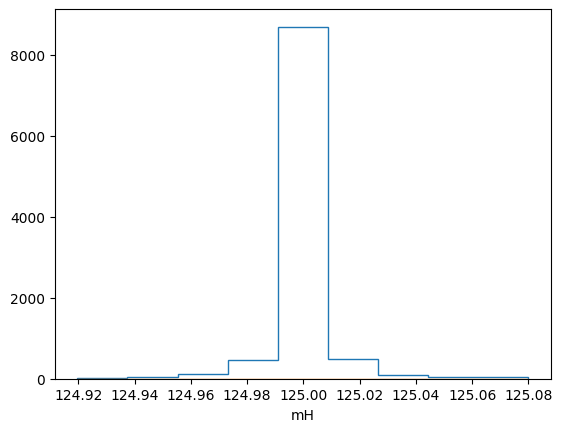

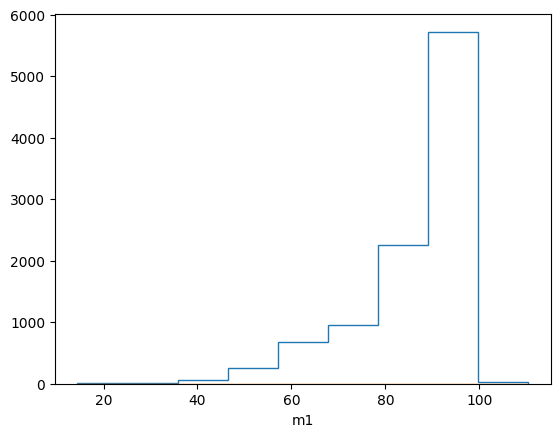

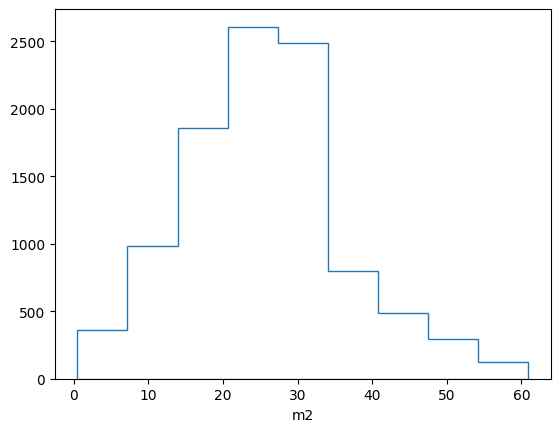

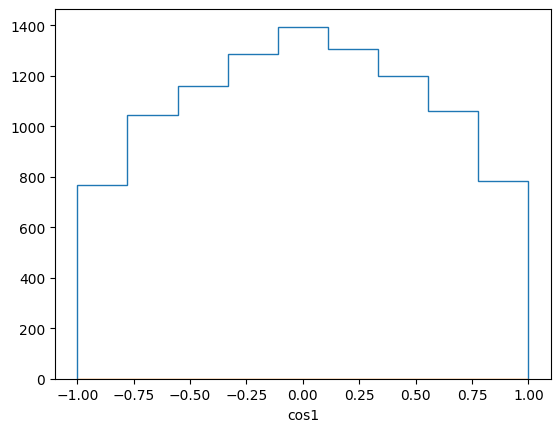

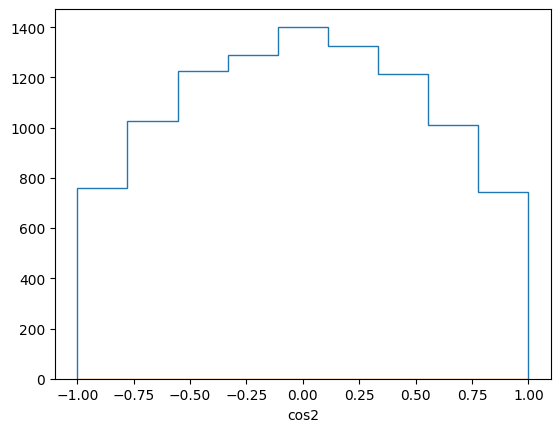

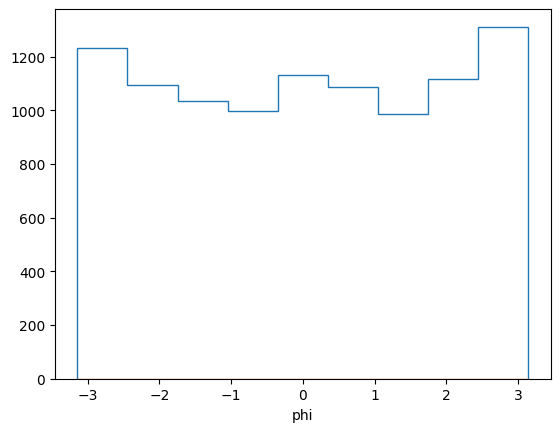

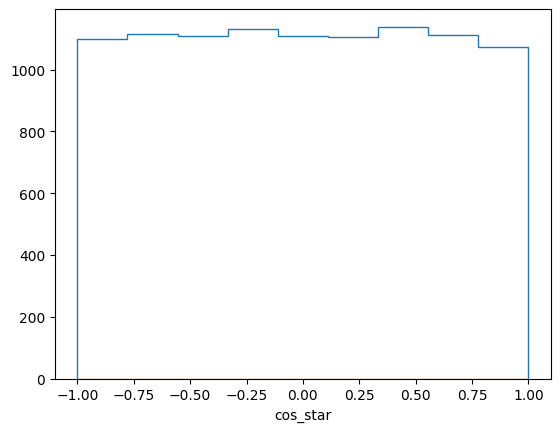

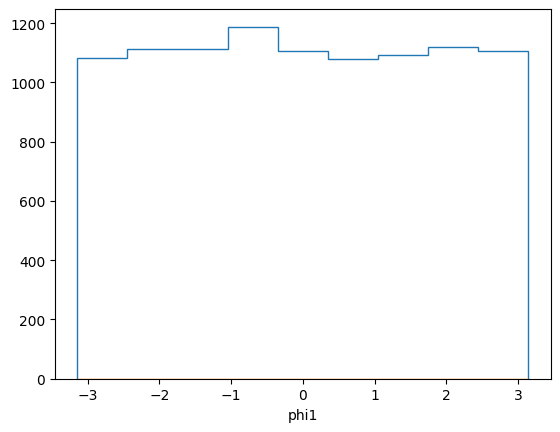

In [82]:
for i, name in enumerate(observable_names):
    plt.figure()
    mini, maxi = observables[i].min(), observables[i].max()
    binning = np.linspace(mini, maxi, 10)
    
    plt.hist(observables[i], binning, histtype="step")
    plt.hist(observables[i], binning, weights=probabilities["tchWB"]/probabilities["SM"], histtype="step")
    
    plt.xlabel(name)
    plt.show()
    plt.close(fig)